In [ ]:
!pip install -U torch  ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 8.3 MB/s eta 0:00:00


In [ ]:

# import & downloading the sam weights
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-49onr5_u
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-49onr5_u
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=1a4b807969ecfed6334cb6537f66cbd524d925b1a967d98058ec69dc6a28b082
  Stored in directory: /tmp/pip-ephem-wheel-cache-sph6dzhr/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-11-11 18:31:28--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

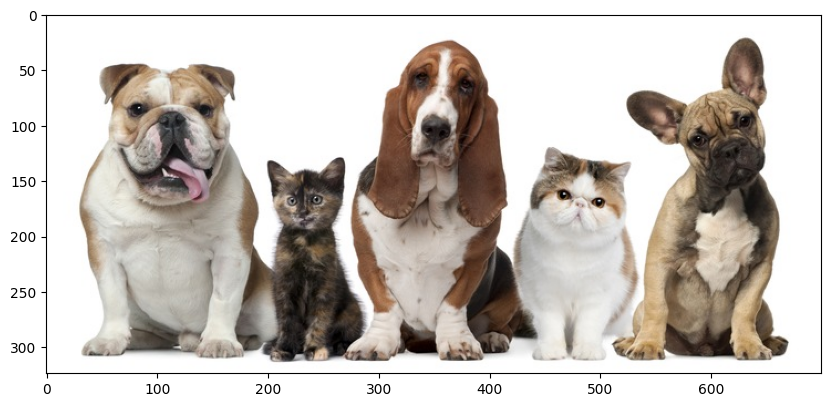

In [38]:
# show the imput image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()


In [44]:
from ultralytics import YOLO
import numpy as np
import cv2
import sys
import torch
from PIL import Image
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

def yolov8_detection(model, image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image, stream=True)  # generator of Results objects
    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
        objects_idx = result.boxes.cls
    bbox = boxes.xyxy.tolist()
    bbox = [[int(i) for i in box] for box in bbox]
    return bbox, image, objects_idx #the order of the annotation results lists are the same


image_path = '/content/images/cat.jpeg'
model=YOLO('/content/yolov8n.pt')

yolov8_boxex, image, objects_idx  = yolov8_detection(model, image_path)

#check yolo labels
names = model.model.names
print(names)

#abstrating objects
objects = [names[int(idx.item())] for idx in objects_idx]
print(objects)

#get the xyxy corordination of each boxing bounding
print(yolov8_boxex)




0: 320x640 2 cats, 4 dogs, 7.7ms
Speed: 1.5ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

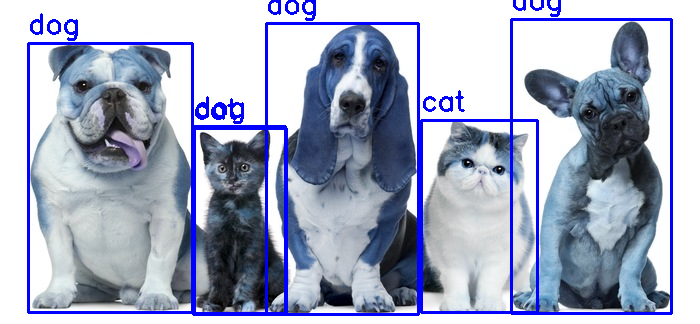

In [43]:
from google.colab.patches import cv2_imshow
import cv2

def draw_boxes(image, boxes, labels):
    for box, label in zip(boxes, labels):
        # Draw rectangle (bounding box)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

        # Draw label
        cv2.putText(image, label, (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Draw bounding boxes and labels on the image
draw_boxes(image, yolov8_boxex, objects)

# Display the image in Colab
cv2_imshow(image)

In [57]:
from ultralytics import YOLO
import numpy as np
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load YOLOv8 and yolo_cls models
model = YOLO('/content/yolov8n.pt')
yolo_cls_model = YOLO('yolov8n-cls.pt')  # yolo_cls model here

def yolov8_detection(model, yolo_cls_model, image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image_rgb, stream=True)

    bbox = []
    labels = []
    for result in results:
        boxes = result.boxes.xyxy
        bbox.extend(boxes.tolist())

        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            cropped_image = image_rgb[y1:y2, x1:x2]
            # Use yolo_cls_model to get the label for each cropped image
            label = yolo_cls_model(cropped_image)
            labels.append(label)

    return bbox, image, labels

# Detection and labeling
image_path = '/content/images/cat.jpeg'
yolov8_boxes2, image, labels = yolov8_detection(model, yolo_cls_model, image_path)

# Print the results
names2 = yolo_cls_model.model.names
print(names2)

  #abstrating objects
objects = [names[int(idx.item())] for idx in objects_idx]
print(objects)

  #get the xyxy corordination of each boxing bounding
print(yolov8_boxes2)





0: 224x224 French_bulldog 0.47, pug 0.26, bull_mastiff 0.16, boxer 0.03, Staffordshire_bullterrier 0.02, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 basset 0.35, Walker_hound 0.21, beagle 0.08, Great_Dane 0.06, Bedlington_terrier 0.05, 3.4ms
Speed: 1.4ms preprocess, 3.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 French_bulldog 0.58, bull_mastiff 0.11, pug 0.10, Staffordshire_bullterrier 0.08, boxer 0.03, 3.2ms
Speed: 1.3ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 Persian_cat 0.32, Japanese_spaniel 0.20, Brabancon_griffon 0.18, Egyptian_cat 0.03, pug 0.02, 3.1ms
Speed: 1.3ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 affenpinscher 0.17, siamang 0.13, skunk 0.13, indri 0.12, schipperke 0.09, 3.3ms
Speed: 1.4ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1

{0: 'n01440764', 1: 'n01443537', 2: 'n01484850', 3: 'n01491361', 4: 'n01494475', 5: 'n01496331', 6: 'n01498041', 7: 'n01514668', 8: 'n01514859', 9: 'n01518878', 10: 'n01530575', 11: 'n01531178', 12: 'n01532829', 13: 'n01534433', 14: 'n01537544', 15: 'n01558993', 16: 'n01560419', 17: 'n01580077', 18: 'n01582220', 19: 'n01592084', 20: 'n01601694', 21: 'n01608432', 22: 'n01614925', 23: 'n01616318', 24: 'n01622779', 25: 'n01629819', 26: 'n01630670', 27: 'n01631663', 28: 'n01632458', 29: 'n01632777', 30: 'n01641577', 31: 'n01644373', 32: 'n01644900', 33: 'n01664065', 34: 'n01665541', 35: 'n01667114', 36: 'n01667778', 37: 'n01669191', 38: 'n01675722', 39: 'n01677366', 40: 'n01682714', 41: 'n01685808', 42: 'n01687978', 43: 'n01688243', 44: 'n01689811', 45: 'n01692333', 46: 'n01693334', 47: 'n01694178', 48: 'n01695060', 49: 'n01697457', 50: 'n01698640', 51: 'n01704323', 52: 'n01728572', 53: 'n01728920', 54: 'n01729322', 55: 'n01729977', 56: 'n01734418', 57: 'n01735189', 58: 'n01737021', 59: 'n

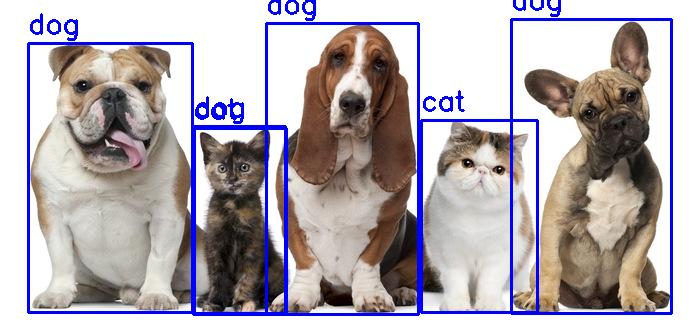

In [46]:
from google.colab.patches import cv2_imshow
import cv2

def draw_boxes(image, boxes, labels):
    for box, label in zip(boxes, labels):
        # Draw rectangle (bounding box)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

        # Draw label
        cv2.putText(image, label, (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Draw bounding boxes and labels on the image
draw_boxes(image, yolov8_boxex, objects)

# Display the image in Colab
cv2_imshow(image)

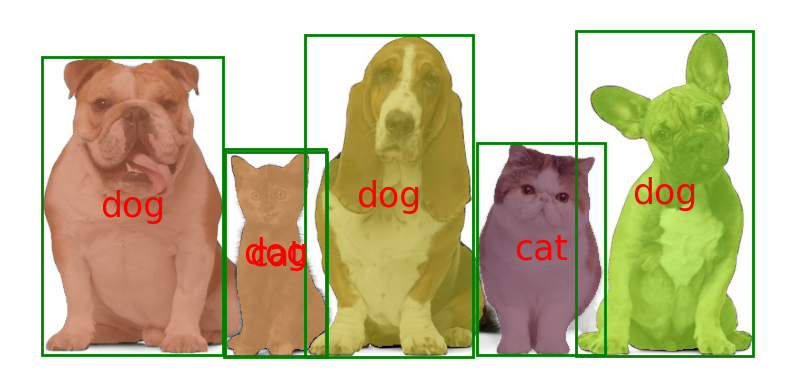

In [37]:

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"
f
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)
input_boxes = torch.tensor(yolov8_boxex, device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

for i, mask in enumerate(masks):

    binary_mask = masks[i].squeeze().numpy().astype(np.uint8)

    # Find the contours of the mask
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    # Get the new bounding box
    bbox = [int(x) for x in cv2.boundingRect(largest_contour)]

    # Get the segmentation mask for object
    segmentation = largest_contour.flatten().tolist()

    # Write bounding boxes to file in YOLO format
    with open('BBOX_yolo.txt', 'w') as f:
        for contour in contours:
            # Get the bounding box coordinates of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Convert the coordinates to YOLO format and write to file
            f.write('0 {:.6f} {:.6f} {:.6f} {:.6f}\n'.format((x+w/2)/image.shape[1], (y+h/2)/image.shape[0], w/image.shape[1], h/image.shape[0]))
            f.write('\n')
    mask=segmentation

        # load the image
    #width, height = image_path.size
    img = Image.open(image_path)
    width, height = img.size

    # convert mask to numpy array of shape (N,2)
    mask = np.array(mask).reshape(-1,2)

    # normalize the pixel coordinates
    mask_norm = mask / np.array([width, height])

    # compute the bounding box
    xmin, ymin = mask_norm.min(axis=0)
    xmax, ymax = mask_norm.max(axis=0)
    bbox_norm = np.array([xmin, ymin, xmax, ymax])

    # concatenate bbox and mask to obtain YOLO format
    yolo = np.concatenate([bbox_norm, mask_norm.reshape(-1)])

    # compute the bounding box
    # write the yolo values to a text file
    with open('yolomask_format.txt', 'w') as f:
        for val in yolo:
            f.write("{:.6f} ".format(val))
        f.write('\n')

    # Print the bounding box and segmentation mask
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
for rect, text in zip(yolov8_boxex, objects):
    # get the matrix central point
    x_center = (rect[0] + rect[2]) / 2
    y_center = (rect[1] + rect[3]) / 2

    # add notes there
    plt.text(x_center, y_center, text, size=25, color='red', ha='center', va='center')

plt.show()